# MHW Calculation and Satellite Climatology

This notebook computes the MHW event statistics as a Python dictionary. It also generates a netcdf of the climtology and threshold values for each of the pixels in the CBay.

- Geo-Polar
- MUR
- OSTIA

- All: identify MHW, save climatology output
- Extras for just Geo-Polar: save event statistics, save threshold output, compute detrended sst and use to identify MHW

Explain dask -- uncomment dask lines (ex. Client()) to use dask backend. Not needed for small datasets, but should speed up processing.

**QUESTION** do we ever use the threshold information? Maybe it doesn't need to be saved (probably not for MUR/OSTIA, but maybe not for geopolar, either?)

In [1]:
import os
import pickle
from typing import Union
import collections
from pathlib import Path
from datetime import datetime, date

import xarray as xr
import numpy as np
from scipy import stats
import pandas as pd
import dask.array as da
from dask.distributed import Client
import marineHeatWaves as mhw

In [2]:
REPO_ROOT = os.getenv('REPO_ROOT', '/Users/rwegener/repos/chesapeake_mhw')
REPO_ROOT = Path(REPO_ROOT)

In [3]:
# Folder in which to store processed climatologies and thresholds
OUTPUT_DIR = REPO_ROOT / 'data/interim'

In [4]:
# dask.config.set({'temporary_directory':'/Users/rwegener/repos/'})

client = Client()

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52511,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52523,Total threads: 2
Dashboard: http://127.0.0.1:52524/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52514,


### Helper functions

The processing in these functions is repeated several times throughout the notebook. That code has been consolidated here and given descriptive names to make reading the notebook easier.

In [6]:
def format_time(time_np: collections.abc.Iterable[Union[datetime, str]]) -> np.ndarray[int]:
    """
    This function converts a datetime string to an ordinal datetime. Ordinal dates
    are required for processing in the marineHeatWaves library.
    Args:
        time_np: an array of datetime strings of the format %Y-%m-%dT%H:%M:%S.000000000

    Returns:
        an array of ordinal dates (ex. 2005156)
    """
    time_dt_list = [datetime.strptime(str(time), '%Y-%m-%dT%H:%M:%S.000000000') 
                    for time in time_np]
    return np.array([time.toordinal() for time in time_dt_list])

In [7]:
def identify_marineheatwaves(sst_np: np.ndarray, time_ordinal: np.ndarray):
    """
    This function uses the marineHeatWave package mhw.detect() and applies it
    to all the pixels in a satellite data image. The output is numpy array of
    the dictionaries that are returned from the mhw.detect() function.

    Args:
        sst_np: a 3D numpy array which gives SST values for a region. Axis 0 should
        be the time axis
        time_ordinal: a 1D numpy array which gives time values corresponding to
        sst_np in ordinal format

    Returns:
        result: A list with two items containing 1) a numpy array with a dictionary
        of marine heatwave statistics for each pixel and 2) a numpy array with the
        climatological and threshold SST for each pixel
    """
    sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

    # define a wrapper to rearrange arguments
    def func1d(arr, time):
        return mhw.detect(time, arr)
    
    def block_func(block, **kwargs):
        return np.apply_along_axis(func1d, 0, block, **kwargs)
    
    result = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
    result = result.compute()
    return result

In [8]:
def extract_numpy_outputs(result: np.ndarray, time_length: int):
    """
    The output from mhw.detect() provides a dictionary which holds the
    climatological and threshold values for each day of the year as 1D arrays.
    This function reshapes the data from this format to a 3D numpy array of shape
    (time, lat, lon) for both climatological and threshold values.

    Args:
        result: output from a marineHeatWaves mhw.detect() function
        time_length: the number of time steps in the time series

    Result:
        two numpy arrays of shape (time, lat, lon), one containing the climatological
        SST values and the other containing the threshold SST values
    """
    # Create 2D empty output arrays
    lat_length, lon_length = result[1].shape
    climatology = np.empty((time_length, lat_length, lon_length))
    threshold = np.empty((time_length, lat_length, lon_length))

    for i in range(result[1].shape[0]):
        for j in range(result[1].shape[1]):
            climatology[:, i, j] = result[1, i, j]['seas']
            threshold[:, i, j] = result[1, i, j]['thresh']

    return climatology, threshold

In [19]:
def detrend_sst(sst_np: np.ndarray, time_ordinal: np.ndarray) -> np.ndarray:
    """
    Given a 3D numpy array of SST values this function returns an SST array with
    the long term warming signal. Long term warming is assumed to be linear.
    """
    sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

    # define a wrapper to rearrange arguments
    def func1d(arr, time):
        def mxplusb(x, m, b):
            return m*x + b
        
        res = stats.linregress(time, arr)
        starting_temp = mxplusb(time[0], res.slope, res.intercept)
        return arr - mxplusb(time, res.slope, res.intercept) + starting_temp
    
    def block_func(block, **kwargs):
        return np.apply_along_axis(func1d, 0, block, **kwargs)
    
    detrended_sst = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
    detrended_sst = detrended_sst.compute()
    return detrended_sst

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **Geo-Polar SST**

### Open Geo-Polar SST

In [11]:
path = (
    REPO_ROOT / 'data/raw' /
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

In [12]:
# convert kelvin to celsius & update metadata
geopolar.values = geopolar.values - 273.15
geopolar.attrs.update({
    'units': 'celsius',
})

In [13]:
geopolar

<xarray.DataArray 'analysed_sst' (time: 7710, lat: 65, lon: 40)>
array([[[      nan,       nan,       nan, ..., 24.73999 , 24.700012,
         24.660004],
        [      nan,       nan,       nan, ..., 24.690002, 24.649994,
         24.609985],
        [      nan,       nan,       nan, ..., 24.639984, 24.600006,
         24.570007],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 24.380005, 24.350006,
         24.329987],
        [      nan,       nan,       nan, ..., 24.339996, 24.309998,
         24.299988],
        [      nan,       nan,       nan, ..., 24.320007, 24.290009,
         24.269989],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ..., 19.420013, 19.329987,
         19.26001 ],
        [      nan,       nan,       nan, ..., 19.359985, 19.269989,
         19.200012],
        [      nan,       nan,       nan, ..., 19.299988, 19.220001,
         19.160004],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-09-01T12:00:00 ... 2023-10-17T12:00:00
  * lat      (lat) float32 36.78 36.83 36.88 36.92 ... 39.83 39.88 39.92 39.97
  * lon      (lon) float32 -77.47 -77.43 -77.38 -77.32 ... -75.62 -75.57 -75.53
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          celsius
    valid_min:      -200
    valid_max:      4000
    reference:      Fieguth,P.W. et al. "Mapping Mediterranean altimeter data...
    source:         STAR-ACSPO_GAC, STAR-ACSPO_H-8, STAR-Geo_SST, UKMO-OSTIA
    comment:        Analysed SST for each ocean grid point
    grid_mapping:   spatial_ref

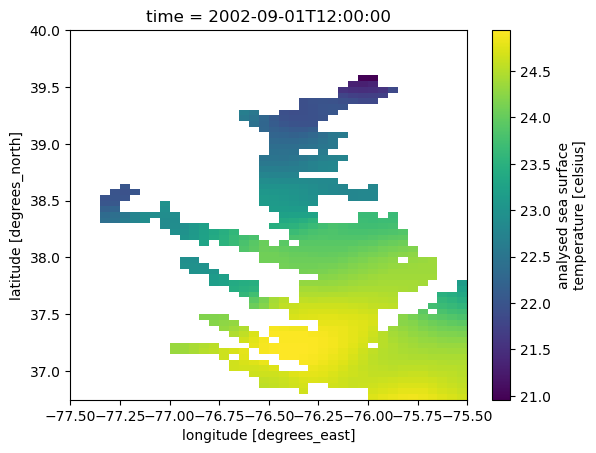

In [13]:
geopolar.isel(time=0).plot()

### Preprocessing

In [14]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(geopolar.time.values)
# Extract numpy array from xarray DataArray
sst_np = geopolar.values

### Identify marine heatwaves with `mhw.detect()` (Geo-Polar)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in ~4 minutes on my computer.

In [15]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/chesapeake_mhw_2021dask/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/rwegener/repos/chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/repos/chesapeake_mhw/notebooks/01_intermediate_processing/marineHeatWaves.py:281: RuntimeWarning: Mean of empty slice
  seas_climYear[d-1] = np.nanmean(tempClim[tt.astype(int)])
/Users/rwegener/miniconda3/envs/

CPU times: user 10.9 s, sys: 3.75 s, total: 14.6 s
Wall time: 4min 3s


The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [16]:
event_statistics = result[0]

In [17]:
clim_np, thresh_np = extract_numpy_outputs(result, len(time_ordinal))

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save Climatological average and 90th percentile threshold

Create an xarray DataArray for the climatology data using numpy output from the MHW calculation

In [18]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords=geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [19]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'geopolar_climatology_chesapeake.nc')

Create an xarray DataArray for the threshold data using numpy output from the MHW calculation

In [20]:
thresh = xr.DataArray(thresh_np, coords=geopolar.coords, dims=geopolar.dims)

# rename variables
thresh = thresh.rename('threshold')

# add array attributes
thresh.attrs['comment'] = '90th percentile treshold values computed using the ' \
    'marineHeatWave package. Uses all defaults from .detect() function - 5 day window' \
    ' half width, 31 day smoothing'
thresh.attrs['source_dataset'] = 'NOAA Geopolar'
thresh.attrs['units'] = 'celsius'
thresh.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [21]:
thresh.to_dataset().to_netcdf(OUTPUT_DIR / 'geopolar_threshold_chesapeake.nc')

### Save the event statistics as a byte stream (pickle) for later processing

In [22]:
with open(OUTPUT_DIR / 'mhw_eventstats_dict.pickle', 'wb') as handle:
    pickle.dump(event_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **Linearly Detrended Geo-Polar SST**

### Open Geo-Polar SST

In [14]:
path = (
    REPO_ROOT / 'data/raw' /
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
)
geopolar = xr.open_dataset(path).analysed_sst

In [15]:
# convert kelvin to celsius & update metadata
geopolar.values = geopolar.values - 273.15
geopolar.attrs.update({
    'units': 'celsius', 
    'valid_min': geopolar.attrs['valid_min'] - 273.15,
    'valid_max': geopolar.attrs['valid_max'] - 273.15,
})

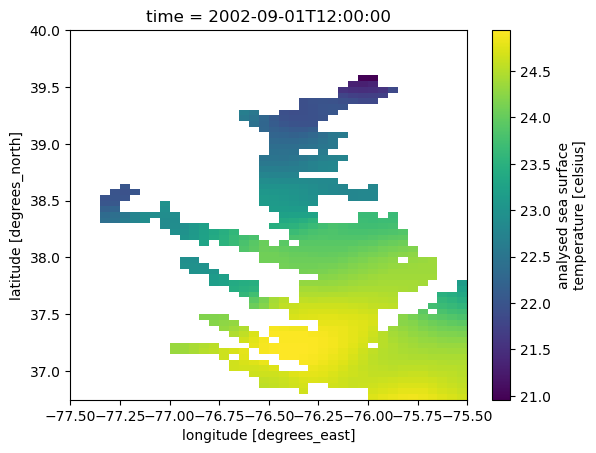

In [16]:
geopolar.isel(time=0).plot()

### Preprocessing

In [17]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(geopolar.time.values)
# Extract numpy array from xarray DataArray
sst_np = geopolar.values

### Detrend the SST data to remove long term warming

Random side thing into confirming the degrees C increase per decade for a review comment

In [ ]:
def sst_trend(sst_np: np.ndarray, time_ordinal: np.ndarray) -> np.ndarray:
    """
    Given a 3D numpy array of SST values this function returns a SST array with
    the long term warming signal. Long term warming is assumed to be linear.
    """
    sst_da = da.from_array(sst_np, chunks=(-1, 20, 20))

    # define a wrapper to rearrange arguments
    def func1d(arr, time):
        def mxplusb(x, m, b):
            return m*x + b
        
        res = stats.linregress(time, arr)
        starting_temp = mxplusb(time[0], res.slope, res.intercept)
        slope_per_decade = res.slope*365*10
        print(slope_per_decade)
        return (res.slope*365*10, res.intercept)
    
    def block_func(block, **kwargs):
        return np.apply_along_axis(func1d, 0, block, **kwargs)
    
    detrended_sst = sst_da.map_blocks(block_func, meta=sst_da, time=time_ordinal)
    detrended_sst = detrended_sst.compute()
    return detrended_sst

In [106]:
time_ordinal

array([731094, 731095, 731096, ..., 738808, 738809, 738810])

In [72]:
out = sst_trend(sst_np, time_ordinal)


1.1989580192557743
1.1930832926542398
1.1832289248361056
nan
nan
nan
nan
nan
nan
1.240689275461606
1.2379174579360357
1.2382788513168286
1.2285758901760109
1.218561439039624
1.2073521881871865
1.192433115790705
1.2006369972972242
1.210133510698588
1.2142794133902937
1.2102253535954852
1.2067573710827175
1.200457768244649
nan
nan
nan
nan
nan
nan
nan
nan
1.2580627087537433
1.2600557729839972
1.2562113945808149
1.2459658395662654
nan
nan
nan
nan
1.2154115611939345
1.2106355694387159
1.2103054549596923
1.2044471919162452
nan
nan
nan
nan
nan
nan
nan
nan
1.2787681454248692
1.288675561232275
1.2954817795490372
1.3024375033590931
nan
nan
nan
nan
1.2154306453106187
1.2107215719117927
nan
1.2051950001584342
nan
nan
nan
nan
nan
nan
nan
1.2711702820903334
1.2915426809603192
1.3142220128573754
1.3276982797315593
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
1.2721635603806796
1.2990539663560041
1.3323281121616977
1.3603159730409584
1.397030474767156
nan
nan
nan
nan
nan
nan
nan
na

In [63]:
np.nanmin(out[0, :])

0.6925484553684764

In [66]:
np.nanmean(out[0, :])

1.215842813384021

In [120]:
np.nanmax(out[0, :])

2.0538364323500815

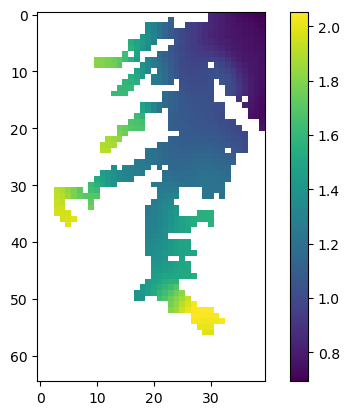

In [121]:
plt.imshow(out[0, :])
plt.colorbar()

In [ ]:
starting_temp = mxplusb(time[0], res.slope, res.intercept)
arr - mxplusb(time, res.slope, res.intercept) + starting_temp

In [76]:
def mxplusb(x, m, b):
    return m*x + b

In [78]:
import matplotlib.pyplot as plt

In [93]:
import matplotlib.dates as mdates

t1 = mdates.date2num(geopolar.time[0].values)
t2 = mdates.date2num(geopolar.time[-1].values)

In [105]:
t1

11931.5

In [101]:
out[1, 25, 25]

-211.1327747056805

In [109]:
mxplusb(time_ordinal, out[0, 25, 25], out[1, 25, 25]) - 

array([823767.14768774, 823768.27473608, 823769.40178442, ...,
       832461.19859705, 832462.32564539, 832463.45269373])

In [103]:
mxplusb(t1, out[0, 25, 25], out[1, 25, 25])

13236.2445165013

In [107]:
out[0, 25, 25]

1.1270483418855115

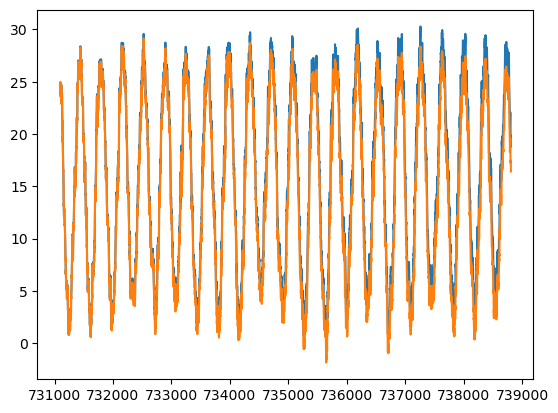

In [116]:
plt.plot(time_ordinal, time_series)
plt.plot(time_ordinal, detrended_sst_np[:, 25, 25])

In [118]:
stats.linregress(time_ordinal, detrended_sst_np[:, 25, 25])

LinregressResult(slope=-4.380637133029501e-19, intercept=14.614698589861932, rvalue=-1.1382978895832895e-16, pvalue=0.999999999999992, stderr=4.383393875899586e-05, intercept_stderr=32.215910173969746)

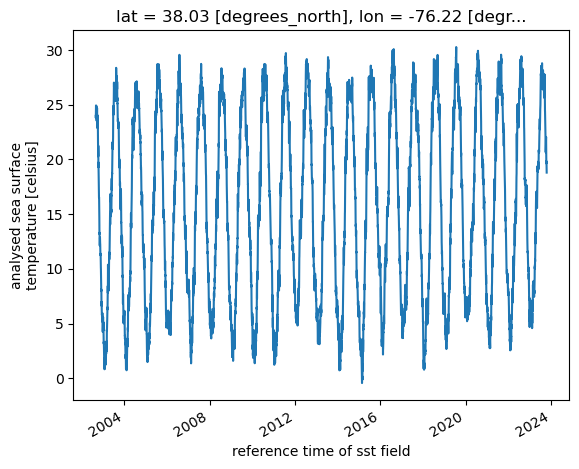

In [104]:
time_series = geopolar.isel(lat=25, lon=25)
time_series.plot()

x1, y1 = t1, mxplusb(t1, out[0, 25, 25], out[1, 25, 25])
x2, y2 = t2, mxplusb(t2, out[0, 25, 25], out[1, 25, 25])

# plt.plot([x1, x2], [y1, y2])

In [112]:
detrended_sst_np[25, 25]

(7710, 65, 40)

Back to normal

In [110]:
%%time

detrended_sst_np = detrend_sst(sst_np, time_ordinal)

0.00028402988420313203
nan
0.00027418339983939684
nan
0.0002690839284888875
nan
0.0002670414095321046
0.0002676425274010411
nan
0.00027010913350680054
nan
nan
nan
0.0002724026107369389
nan
0.0002659818086789751
nan
0.00025490994413955093
nan
0.00024093399199944158
nan
0.00022815487504066197
nan
0.00021913855503229604
0.00044763015584613924
0.0002132461127447351
0.00021002422182057185
0.00020786626352592717
nan
0.00033341974308419373
0.0004615684246424533
0.00047716659737716933
0.0003197664226768619
0.0004945848043509705
0.0005127456904637218
0.0005313611817699269
0.0003024174927289125
nan
0.00028654600165623135
nan
0.00027541167200456266
nan
0.0002719435942187082
nan
0.00027030344787496965
nan
0.0002714513415404853
nan
0.0002737659377759858
nan
0.0002787865668598568
nan
0.0002808851372348012
0.00027598963580531544
nan
0.0002668875595481782
nan
0.0002512110917825342
nan
0.00023569913704894134
nan
0.00022374340689129745
nan
0.00021536971064990037
nan
0.00021100652646243204
nan
0.00020837

In [28]:
detrended_sst_np.shape

(7710, 65, 40)

### Identify marine heatwaves with `mhw.detect()` (Linearly detrended Geo-Polar)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in ~3 minutes on my computer.

In [29]:
%%time

result = identify_marineheatwaves(detrended_sst_np, time_ordinal)

CPU times: user 11.1 s, sys: 3.82 s, total: 15 s
Wall time: 4min 2s


The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [30]:
event_statistics = result[0]

In [31]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save Climatological average and 90th percentile threshold

Create an xarray DataArray for the climatology data using numpy output from the MHW calculation

In [32]:
# create xarray objects from numpy output of mhw
clim = xr.DataArray(clim_np, coords = geopolar.coords, dims=geopolar.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing.' \
    'Input SST was linearly detrended to remove long term warming.'

clim.attrs['source_dataset'] = 'NOAA Geopolar'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [33]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'geopolar_climatology_chesapeake_detrended.nc')

### Save the event statistics as a byte stream (pickle) for later processing

In [22]:
with open(OUTPUT_DIR / 'mhw_eventstats_dict_detrended.pickle', 'wb') as handle:
    pickle.dump(event_statistics, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **MUR SST**

### Open MUR SST

In [34]:
path = (
    REPO_ROOT / 'data/raw' / 
    'MUR-JPL-L4_GHRSST-SSTfnd-GLOB-v02.0-fv04.1-20020901_20230831.nc'
)
mur = xr.open_dataset(path).analysed_sst

In [35]:
# convert kelvin to celsius & update metadata
mur.values = mur.values - 273.15
mur.attrs.update({
    'units': 'celsius', 
})

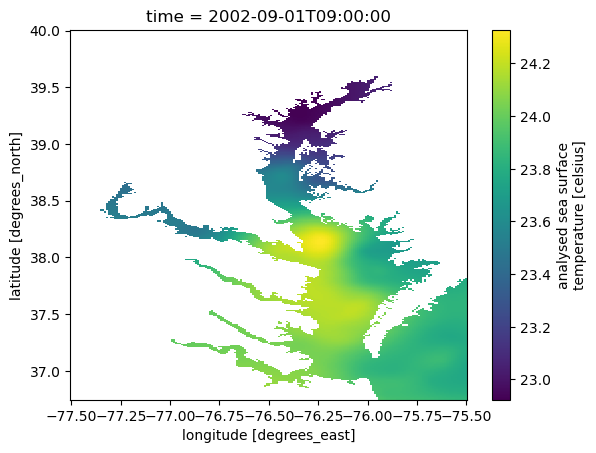

In [36]:
mur.isel(time=0).plot()

### Preprocessing

In [37]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(mur.time.values)
# Extract numpy array from xarray DataArray
sst_np = mur.values

### Identify marine heatwaves with `mhw.detect()` (MUR)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in **XXX** minutes on my computer.

Oh my gosh this took 1 hour and 20 minutes to run for MUR. Good grief.

I guess it is about a linear scale from the Geopolar. 3min for geopolar * 25 times as many grid cells.

In [38]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

CPU times: user 10min 43s, sys: 3min 1s, total: 13min 44s
Wall time: 1h 29min 21s


In [39]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))
# threshold output from MUR is ignored since it is not used

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save climatological average

In [ ]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords = mur.coords, dims=mur.dims)

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'NASA MUR'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [ ]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'mur_climatology_chesapeake.nc')

## Calculate Marine Heatwaves using `marineHeatWaves` Package: **OSTIA SST**

### Open OSTIA SST

In [ ]:
path = (
    REPO_ROOT / 'data/raw' / 
    'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_analysed_sst_77.47W-75.53W_36.78N-39.97N_2007-01-01-2023-09-01.nc'
)
ostia = xr.open_dataset(path).analysed_sst

In [ ]:
# convert kelvin to celsius & update metadata
ostia.values = ostia.values - 273.15
ostia.attrs.update({
    'units': 'celsius', 
})

In [ ]:
ostia.isel(time=0).plot()

### Preprocessing

In [ ]:
# Convert datetimes to ordinal time format
time_ordinal = format_time(ostia.time.values)
# Extract numpy array from xarray DataArray
sst_np = ostia.values

### Identify marine heatwaves with `mhw.detect()` (OSTIA)

Identify marine heatwaves using the `mhw.detect()` function from the marineHeatWaves Python package. The marineHeatWaves package can only process one time series of temperature data at a time (ex. one pixel of data over a period of time). The `identify_marineheatwaves()` function here wraps `mhw.detect()` and applies it to all the pixels in a satellite image.

`identify_marineheatwaves()` can take some time, depending on the size of the dataset. This step typically ran in 4 minutes on my computer.

In [ ]:
%%time

result = identify_marineheatwaves(sst_np, time_ordinal)

The `mhw.detect()` function returns two sets things:
1. (index 0) The MHW event statistics for all the events
2. (index 1) A dictionary containing the climatology (`seas`), threshold (`thresh`) and missing (`missing`) values from the array
These two things are axis 0 and 1, respectively, of the `res` array that gets returned from the `.compute()` above. Each of these two outputs is produced for every pixel location of the array.

Below we split these two pieces into different datasets to save them.

In [ ]:
event_statistics = result[0]

In [ ]:
clim_np, _ = extract_numpy_outputs(result, len(time_ordinal))
# threshold output from OSTIA is ignored since it is not used

Note that the output of this function is of the same length as time_ordinal. The daily climatological values are repeated multiple times to match length.

### Save climatological average

In [ ]:
# create xarray object from numpy output of mhw
clim = xr.DataArray(clim_np, coords = ostia.coords, dims=ostia.dims)
clim = clim.rename({'latitude': 'lat', 'longitude': 'lon'})

# rename variables
clim = clim.rename('climatology')

# add array attributes
clim.attrs['comment'] = 'climatology computed using the marineHeatWave package. ' \
    'Uses all defaults from .detect() function - 5 day window half width, 31 day smoothing' \

clim.attrs['source_dataset'] = 'Copernicus OSTIA'
clim.attrs['units'] = 'celsius'
clim.attrs['processing_date'] = datetime.strftime(date.today(), '%Y-%m-%d')

In [ ]:
clim.to_dataset().to_netcdf(OUTPUT_DIR / 'ostia_climatology_chesapeake.nc')